In [53]:
!pip install gpytorch
!pip install torchbnn
import gpytorch
import os
import numpy as np
import pandas as pd
import warnings 
warnings.filterwarnings("ignore") 
import time 
import random
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
import sklearn.gaussian_process as gp 
from sklearn.gaussian_process.kernels import DotProduct as lin, WhiteKernel, RBF, ConstantKernel, RBF, WhiteKernel, RationalQuadratic, Exponentiation
import matplotlib.pyplot as plt

In [54]:
import torch
from torch._C import device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import MultiStepLR
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
import torchvision.transforms as transforms

In [55]:
from gpytorch.means import ConstantMean, LinearMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from gpytorch.variational import VariationalStrategy, CholeskyVariationalDistribution
from gpytorch.distributions import MultivariateNormal
from gpytorch.models import ApproximateGP, GP
from gpytorch.mlls import VariationalELBO, AddedLossTerm
from gpytorch.likelihoods import GaussianLikelihood, MultitaskGaussianLikelihood
from gpytorch.models.deep_gps import DeepGPLayer, DeepGP
from gpytorch.mlls import DeepApproximateMLL 

In [56]:
from google.colab import drive 
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
df_1 = pd.read_csv('drive/MyDrive/Auto/Data/Non_Linear/non_linear_error_1.csv')
drop = ['time_step_H'] 

for j in df_1.columns:
  if len(j) >= 7 and j[:7] == 'Unnamed':
    df_1.drop(j, axis = 1, inplace =True)

for i in drop:
  df_1.drop(i, axis = 1, inplace = True) 

In [6]:
df_1

time_step_A   theta_H   theta_A  ...     acc_s   error_1     error_2
0              0.00  0.000000  1.000000  ...  3.502266  0.000998  198.163232
1              0.01  0.001000  1.000000  ...  3.498148  0.002164  198.109886
2              0.02  0.002000  0.999998  ...  3.492086  0.003330  197.952367
3              0.03  0.003000  0.999996  ...  3.484085  0.004496  197.690856
4              0.04  0.004000  0.999992  ...  3.474151  0.005660  197.325593
...             ...       ...       ...  ...       ...       ...         ...
99996        999.96 -0.509811  0.860287  ... -0.005200 -4.009084    7.451680
99997        999.97 -0.508950  0.860796  ... -0.005190 -4.005187    7.449028
99998        999.98 -0.508089  0.861304  ... -0.005179 -4.001271    7.446377
99999        999.99 -0.507228  0.861812  ... -0.005168 -3.997339    7.443727
100000      1000.00 -0.506366  0.862319  ... -0.005157 -3.993390    7.441078

[100001 rows x 17 columns]

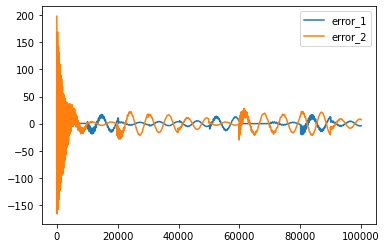

In [7]:
plt.plot(df_1['error_1'], label = 'error_1') 
plt.plot(df_1['error_2'], label = 'error_2')
plt.legend()

In [39]:
k = len(df_1)//100 * (80)
Batch_size = 1024

ss = StandardScaler()

X = torch.from_numpy(ss.fit_transform(df_1.iloc[:k, :-2])).float().to(device)  #train X
Y_1 = torch.from_numpy( df_1.iloc[:k, -2:-1].to_numpy() ).float().to(device) #test Y
dataset_1 = TensorDataset(X, Y_1)
data_loader_1 = DataLoader(dataset_1, batch_size=Batch_size, shuffle = False)   

In [40]:
Y_2 = torch.from_numpy( df_1.iloc[:k, -1:].to_numpy() ).float().to(device)
dataset_2 = TensorDataset(X, Y_2)
data_loader_2 = DataLoader(dataset_2, batch_size=Batch_size, shuffle = False) 

In [41]:
Test_X = torch.from_numpy(ss.fit_transform(df_1.iloc[k:, :-2])).float().to(device)
Test_Y_1 = torch.from_numpy( df_1.iloc[k:, -2:-1].to_numpy() ).float().to(device)
Test_Y_2 = torch.from_numpy( df_1.iloc[k:, -1:].to_numpy() ).float().to(device)

Test_dataset_1 = TensorDataset(Test_X, Test_Y_1)
Test_dataset_2 = TensorDataset(Test_X, Test_Y_2)

test_data_loader_1 = DataLoader(Test_dataset_1, batch_size=Batch_size, shuffle= False)
test_data_loader_2 = DataLoader(Test_dataset_2, batch_size=Batch_size, shuffle= False)

In [58]:
class ToyDeepGPHiddenLayer(DeepGPLayer):
    def __init__(self, input_dims, output_dims, num_inducing=128, mean_type='constant'):
        if output_dims is None:
            inducing_points = torch.randn(num_inducing, input_dims)
            batch_shape = torch.Size([])
        else:
            inducing_points = torch.randn(output_dims, num_inducing, input_dims)
            batch_shape = torch.Size([output_dims])

        variational_distribution = CholeskyVariationalDistribution(
            num_inducing_points=num_inducing,
            batch_shape=batch_shape
        )

        variational_strategy = VariationalStrategy(
            self,
            inducing_points,
            variational_distribution,
            learn_inducing_locations=True
        )

        super(ToyDeepGPHiddenLayer, self).__init__(variational_strategy, input_dims, output_dims)

        if mean_type == 'constant':
            self.mean_module = ConstantMean(batch_shape=batch_shape)
        else:
            self.mean_module = LinearMean(input_dims)
        self.covar_module = ScaleKernel(
            RBFKernel(batch_shape=batch_shape, ard_num_dims=input_dims),
            batch_shape=batch_shape, ard_num_dims=None
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

    def __call__(self, x, *other_inputs, **kwargs):
        """
        Overriding __call__ isn't strictly necessary, but it lets us add concatenation based skip connections
        easily. For example, hidden_layer2(hidden_layer1_outputs, inputs) will pass the concatenation of the first
        hidden layer's outputs and the input data to hidden_layer2.
        """
        if len(other_inputs):
            if isinstance(x, gpytorch.distributions.MultitaskMultivariateNormal):
                x = x.rsample()

            processed_inputs = [
                inp.unsqueeze(0).expand(gpytorch.settings.num_likelihood_samples.value(), *inp.shape)
                for inp in other_inputs
            ]

            x = torch.cat([x] + processed_inputs, dim=-1)

        return super().__call__(x, are_samples=bool(len(other_inputs))) 

num_hidden_dgp_dims = 3 # 2 if smoke_test else 10


class DeepGp(DeepGP):
    def __init__(self, train_x_shape):
        
        hidden_layer = ToyDeepGPHiddenLayer(
            input_dims=train_x_shape[-1],
            output_dims=num_hidden_dgp_dims,
            mean_type='linear',
        )

        last_layer = ToyDeepGPHiddenLayer(
            input_dims=hidden_layer.output_dims,
            output_dims=None,
            mean_type='constant',
        )

        super().__init__() 

        self.hidden_layer = hidden_layer 
        self.last_layer = last_layer 
        self.likelihood = GaussianLikelihood()

    def forward(self, inputs): 
        hidden_rep1 = self.hidden_layer(inputs)
        output = self.last_layer(hidden_rep1)
        return output

    def predict(self, test_loader):
        with torch.no_grad():
            mus = []
            variances = []
            
            #lls = []
            
            for x_batch, y_batch in test_loader:
                preds = self.likelihood(self(x_batch))
                mus.append(preds.mean)
                variances.append(preds.variance)
                #lls.append(model.likelihood.log_marginal(y_batch, model(x_batch)))

        return torch.cat(mus, dim=-1), torch.cat(variances, dim=-1)#, torch.cat(lls, dim=-1) 

In [59]:
model_1 = DeepGp(X.shape)
model_2 = DeepGp(X.shape) 

model_1 = model_1.to(device)
model_2 = model_2.to(device)


In [61]:
Batch_size

256

#Training

In [44]:
import tqdm 

num_epochs = 500
num_samples = 2

optimizer_1 = torch.optim.Adam([
    {'params': model_1.parameters()},
], lr=0.01)

mll_1 = DeepApproximateMLL(VariationalELBO(model_1.likelihood, model_1, X.shape[-2]))

epochs_iter = tqdm.notebook.tqdm(range(num_epochs), desc="Epoch")

total_loss_1 = []

for i in epochs_iter:
  # Within each iteration, we will go over each minibatch of data
  minibatch_iter = tqdm.notebook.tqdm(data_loader_1, desc="Minibatch", leave=False)
  loss_epoch_list = [] 
  for x_batch, y_batch in minibatch_iter:
    with gpytorch.settings.num_likelihood_samples(num_samples):
      optimizer_1.zero_grad()
      output = model_1(x_batch)
      loss = -mll_1(output, y_batch.resize(y_batch.size()[0])) 
      loss.backward()
      optimizer_1.step()

      loss_epoch_list.append(loss.item()) 

      minibatch_iter.set_postfix(loss=loss.item())
  total_loss_1.append(np.mean(loss_epoch_list)) 


Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Non_Linear_Loss_error_1')

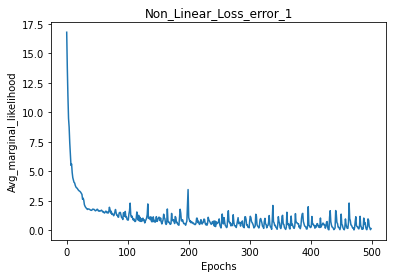

In [45]:
plt.plot(total_loss_1)
plt.xlabel('Epochs') 
plt.ylabel('Avg_marginal_likelihood')
plt.title('Non_Linear_Loss_error_1')
plt.savefig('drive/MyDrive/Auto/DEEP_GP/Non_linear_single_class/Non_Linear_loss_error_1.png')

In [17]:
num_epochs = 500
num_samples = 2

optimizer_2 = torch.optim.Adam([
    {'params': model_2.parameters()},
], lr=0.01)

mll_2 = DeepApproximateMLL(VariationalELBO(model_2.likelihood, model_2, X.shape[-2])) 

epochs_iter = tqdm.notebook.tqdm(range(num_epochs), desc="Epoch")

total_loss_2 = []

for i in epochs_iter:
  # Within each iteration, we will go over each minibatch of data
  minibatch_iter = tqdm.notebook.tqdm(data_loader_2, desc="Minibatch", leave=False)
  loss_epoch_list = [] 
  for x_batch, y_batch in minibatch_iter:
    with gpytorch.settings.num_likelihood_samples(num_samples):
      optimizer_2.zero_grad()
      output = model_2(x_batch)
      loss = -mll_2(output, y_batch.resize(y_batch.size()[0])) 
      loss.backward()
      optimizer_2.step()

      loss_epoch_list.append(loss.item()) 

      minibatch_iter.set_postfix(loss=loss.item())
  total_loss_2.append(np.mean(loss_epoch_list)) 



Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/79 [00:00<?, ?it/s]

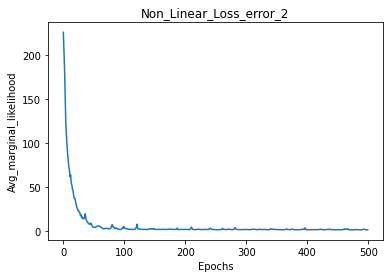

In [18]:
plt.plot(total_loss_2)
plt.xlabel('Epochs') 
plt.ylabel('Avg_marginal_likelihood')
plt.title('Non_Linear_Loss_error_2')
plt.savefig('drive/MyDrive/Auto/DEEP_GP/Non_linear_single_class/Non_Linear_loss_error_2.png')


In [19]:
torch.save(model_1.state_dict(), 'drive/MyDrive/Auto/DEEP_GP/Non_linear_single_class/NonLinear_uni_error_1_csv_1.pth') 

In [ ]:
torch.save(model_2.state_dict(), 'drive/MyDrive/Auto/DEEP_GP/Non_linear_single_class/NonLinear_uni_error_2_csv_1.pth') 

#Testing

In [65]:
state_dict_1 = torch.load('drive/MyDrive/Auto/DEEP_GP/Non_linear_single_class/NonLinear_uni_error_1_csv_1.pth')
state_dict_2 = torch.load('drive/MyDrive/Auto/DEEP_GP/Non_linear_single_class/NonLinear_uni_error_2_csv_1.pth')
model_1.load_state_dict(state_dict_1)
model_2.load_state_dict(state_dict_2)

<All keys matched successfully>

In [66]:
model_1.eval()

DeepGp(
  (hidden_layer): ToyDeepGPHiddenLayer(
    (variational_strategy): VariationalStrategy(
      (_variational_distribution): CholeskyVariationalDistribution()
    )
    (mean_module): LinearMean()
    (covar_module): ScaleKernel(
      (base_kernel): RBFKernel(
        (raw_lengthscale_constraint): Positive()
        (distance_module): Distance()
      )
      (raw_outputscale_constraint): Positive()
    )
  )
  (last_layer): ToyDeepGPHiddenLayer(
    (variational_strategy): VariationalStrategy(
      (_variational_distribution): CholeskyVariationalDistribution()
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): RBFKernel(
        (raw_lengthscale_constraint): Positive()
        (distance_module): Distance()
      )
      (raw_outputscale_constraint): Positive()
    )
  )
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
)

In [67]:
model_2.eval()


DeepGp(
  (hidden_layer): ToyDeepGPHiddenLayer(
    (variational_strategy): VariationalStrategy(
      (_variational_distribution): CholeskyVariationalDistribution()
    )
    (mean_module): LinearMean()
    (covar_module): ScaleKernel(
      (base_kernel): RBFKernel(
        (raw_lengthscale_constraint): Positive()
      )
      (raw_outputscale_constraint): Positive()
    )
  )
  (last_layer): ToyDeepGPHiddenLayer(
    (variational_strategy): VariationalStrategy(
      (_variational_distribution): CholeskyVariationalDistribution()
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): RBFKernel(
        (raw_lengthscale_constraint): Positive()
      )
      (raw_outputscale_constraint): Positive()
    )
  )
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
)

In [47]:
mean_1, variance_1 = [], []

with torch.no_grad():
  for X, y in test_data_loader_1:
    preds = model_1.likelihood(model_1(X))
    mean_1.append(preds.mean.mean(0))
    variance_1.append(preds.variance.mean(0))

  prediction_1 = torch.cat(mean_1, dim = -1).cpu()
  var_1 = torch.cat(variance_1, dim = -1).cpu()

confidence_1 = 1.96 * np.sqrt(var_1) 

In [48]:
len(prediction_1)

20001

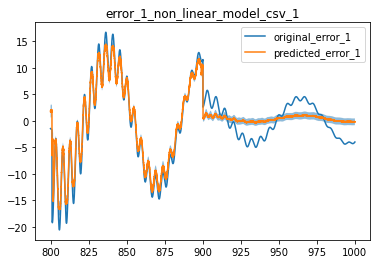

In [49]:
k = len(df_1)//100 * (80)
plt.title('error_1_non_linear_model_csv_1')
plt.plot(df_1.loc[k:,'time_step_A'].values, df_1.iloc[k:, -2:-1], label = 'original_error_1') 
plt.plot(df_1.loc[k:, 'time_step_A'].values, prediction_1, label='predicted_error_1' )
plt.fill_between(df_1.loc[k:, 'time_step_A'].values, prediction_1 + confidence_1, prediction_1 - confidence_1, alpha=0.5)
plt.legend() 
plt.savefig('drive/MyDrive/Auto/DEEP_GP/Non_linear_single_class/error_1_non_linear_model_csv_1.png') 

In [34]:
mean_2, variance_2 = [], []

with torch.no_grad():
  for X, y in test_data_loader_2:
    preds = model_2.likelihood(model_2(X))
    mean_2.append(preds.mean.mean(0))
    variance_2.append(preds.variance.mean(0))

  prediction_2 = torch.cat(mean_2, dim = -1).cpu()
  var_2 = torch.cat(variance_2, dim = -1).cpu()

confidence_2 = 1.96 * np.sqrt(var_2) 

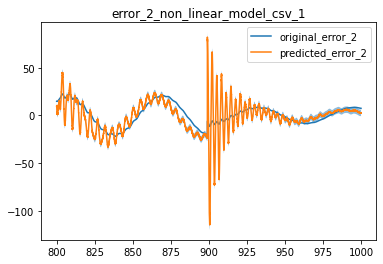

In [35]:
k = len(df_1)//100 * (80)
plt.title('error_2_non_linear_model_csv_1') 
plt.plot(df_1.loc[k:,'time_step_A'].values, df_1.iloc[k:, -1], label = 'original_error_2') 
plt.plot(df_1.loc[k:, 'time_step_A'].values, prediction_2, label='predicted_error_2' )
plt.fill_between(df_1.loc[k:, 'time_step_A'].values, prediction_2 + confidence_2, prediction_2 - confidence_2, alpha=0.5)
plt.legend() 
plt.savefig('drive/MyDrive/Auto/DEEP_GP/Non_linear_single_class/error_2_non_linear_model_csv_1.png') 

#TEST

In [68]:
df = pd.read_csv('drive/MyDrive/Auto/Data/Non_Linear_Test/Non_Test_data_1.csv')
drop = ['time_step_H'] 

for j in df.columns:
  if len(j) >= 7 and j[:7] == 'Unnamed':
    df.drop(j, axis = 1, inplace =True)


df.drop('time_step_H', axis = 1, inplace = True)

Batch_size = 1024

ss = StandardScaler()

X = torch.from_numpy(ss.fit_transform(df.iloc[:, :-2])).float().to(device)  #train X
Y_1 = torch.from_numpy( df.iloc[:, -2:-1].to_numpy() ).float().to(device) #test Y
Y_2 = torch.from_numpy( df.iloc[:, -1:].to_numpy() ).float().to(device) 

DATA_1 = TensorDataset(X, Y_1)
DATA_2 = TensorDataset(X, Y_2)

data_loader_1 = DataLoader(DATA_1, batch_size=Batch_size, shuffle = False) 
data_loader_1 = DataLoader(DATA_2 , batch_size=Batch_size, shuffle = False) 

In [69]:
mean_1, variance_1 = [], []

with torch.no_grad():
  for X, y in data_loader_1:
    preds = model_1.likelihood(model_1(X))
    mean_1.append(preds.mean.mean(0))
    variance_1.append(preds.variance.mean(0))

  prediction_1 = torch.cat(mean_1, dim = -1).cpu()
  var_1 = torch.cat(variance_1, dim = -1).cpu()

confidence_1 = 1.96 * np.sqrt(var_1)  

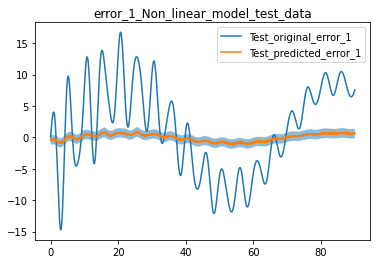

In [70]:
plt.title('error_1_Non_linear_model_test_data') 
plt.plot(df.loc[:,'time_step_A'].values, df.iloc[:, -2:-1], label = 'Test_original_error_1') 
plt.plot(df.loc[:, 'time_step_A'].values, prediction_1, label='Test_predicted_error_1' ) 
plt.fill_between(df.loc[:, 'time_step_A'].values, prediction_1 + confidence_1, prediction_1 - confidence_1, alpha=0.5)
plt.legend() 
#plt.savefig('drive/MyDrive/Auto/DEEP_GP/Non_linear_single_class/error_1_Non_linear_model_test_data.png')

In [31]:
mean_2, variance_2 = [], []

with torch.no_grad():
  for X, y in data_loader_1:
    preds = model_2.likelihood(model_2(X))
    mean_2.append(preds.mean.mean(0))
    variance_2.append(preds.variance.mean(0))

  prediction_2 = torch.cat(mean_2, dim = -1).cpu()
  var_2 = torch.cat(variance_2, dim = -1).cpu()

confidence_2 = 1.96 * np.sqrt(var_2)  

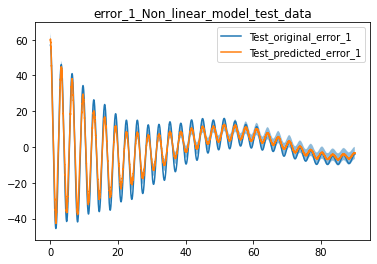

In [32]:
plt.title('error_1_Non_linear_model_test_data') 
plt.plot(df.loc[:,'time_step_A'].values, df.iloc[:, -1:], label = 'Test_original_error_1') 
plt.plot(df.loc[:, 'time_step_A'].values, prediction_2, label='Test_predicted_error_1' ) 
plt.fill_between(df.loc[:, 'time_step_A'].values, prediction_2 + confidence_2, prediction_2 - confidence_2, alpha=0.5)
plt.legend()  
plt.savefig('drive/MyDrive/Auto/DEEP_GP/Non_linear_single_class/error_2_Non_linear_model_test_data.png')

#CSV_2

In [57]:
df_1 = pd.read_csv('drive/MyDrive/Auto/Data/Non_Linear/non_linear_error_2.csv')
drop = ['time_step_H'] 

for j in df_1.columns:
  if len(j) >= 7 and j[:7] == 'Unnamed':
    df_1.drop(j, axis = 1, inplace =True)

for i in drop:
  df_1.drop(i, axis = 1, inplace = True) 



In [101]:

Batch_size = 2048

ss = StandardScaler()

X = torch.from_numpy(ss.fit_transform(df_1.iloc[:, :-2])).float().to(device)  #train X
Y_1 = torch.from_numpy( df_1.iloc[:, -2:-1].to_numpy() ).float().to(device) #test Y
dataset_1 = TensorDataset(X, Y_1)
data_loader_1 = DataLoader(dataset_1, batch_size=Batch_size, shuffle = False)   

Y_2 = torch.from_numpy( df_1.iloc[:, -1:].to_numpy() ).float().to(device)
dataset_2 = TensorDataset(X, Y_2)
data_loader_2 = DataLoader(dataset_2, batch_size=Batch_size, shuffle = False) 




In [102]:
mean_1, variance_1 = [], []

with torch.no_grad():
  for X, y in data_loader_1:
    preds = model_1.likelihood(model_1(X))
    mean_1.append(preds.mean.mean(0))
    variance_1.append(preds.variance.mean(0))

  prediction_1 = torch.cat(mean_1, dim = -1).cpu()
  var_1 = torch.cat(variance_1, dim = -1).cpu()

confidence_1 = 2 * np.sqrt(var_1) 

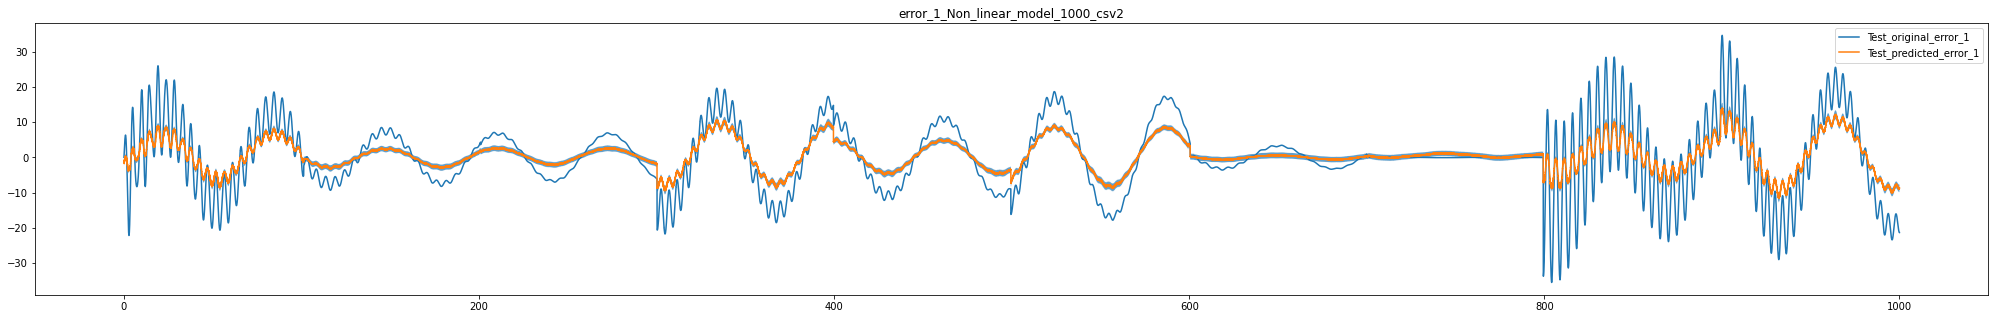

In [106]:
plt.figure(figsize=(35,5))
plt.title('error_1_Non_linear_model_1000_csv2')
plt.plot(df_1.loc[:,'time_step_A'].values, df_1.iloc[:, -2:-1], label = 'Test_original_error_1') 
plt.plot(df_1.loc[:, 'time_step_A'].values, prediction_1, label='Test_predicted_error_1' ) 
plt.fill_between(df_1.loc[:, 'time_step_A'].values, prediction_1 + confidence_1, prediction_1 - confidence_1, alpha=0.7)

plt.legend()
plt.savefig('drive/MyDrive/Auto/DEEP_GP/Non_linear_single_class/error_1_Non_linear_model_1000_csv2.png')

In [104]:
mean_2, variance_2 = [], []

with torch.no_grad():
  for X, y in data_loader_2:
    preds = model_2.likelihood(model_2(X))
    mean_2.append(preds.mean.mean(0))
    variance_2.append(preds.variance.mean(0))

  prediction_2 = torch.cat(mean_2, dim = -1).cpu()
  var_2 = torch.cat(variance_2, dim = -1).cpu()

confidence_2 = 1.96 * np.sqrt(var_2)  

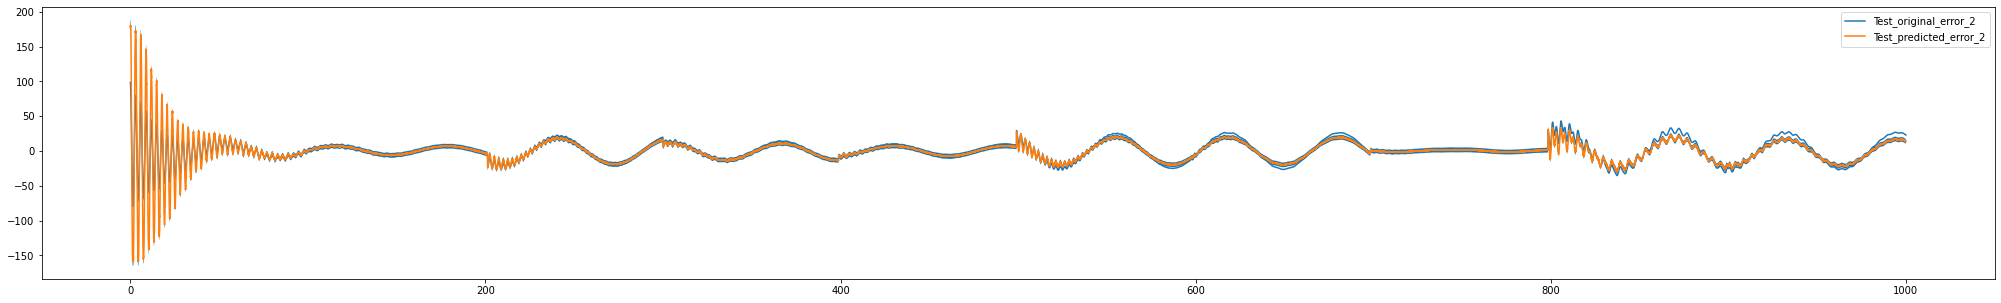

In [107]:
plt.figure(figsize=(35,5))

plt.plot(df_1.loc[:,'time_step_A'].values, df_1.iloc[:, -1:], label = 'Test_original_error_2') 
plt.plot(df_1.loc[:, 'time_step_A'].values, prediction_2, label='Test_predicted_error_2' ) 
plt.fill_between(df_1.loc[:, 'time_step_A'].values, prediction_2 + confidence_2, prediction_2 - confidence_2, alpha=1)
plt.legend()  
plt.savefig('drive/MyDrive/Auto/DEEP_GP/Non_linear_single_class/error_2_Non_linear_model_1000_csv2.png')